In [1]:
#######################################################################################
# Read Me Section:
## Name:
# Kaylen Smith Darnbrook
# Student ID:
# 2135667
# Course:
# M.S.c Machine Learning and Artificial Intelligence
# Module:
## FaceGeneration and Analysis:
## Description: 
# This module is responsible for creating the experimentation and creation of
# pipeline for the generation of faces using the Generative Accumulation Of Photons.
# The module will also be responsible for the analysis of the faces generated.
#####################################################################################

In [2]:
# Import Relevant Libraries:

# Import modules for system managment, io and file management 
import os 
import sys
import time 
import random

# Import modules for data manipulation and analysis
import numpy as np
import pandas as pd
import scipy as sp

# Import modules for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook")
import plotly.express as px
from PIL import Image
import cv2
from albumentations.core.transforms_interface import ImageOnlyTransform

# Import modules for Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
torch.set_float32_matmul_precision('medium')
from torchviz import make_dot
from tqdm import tqdm

# Pytorch Lightning Modules:
import pytorch_lightning as pL
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.callbacks import LearningRateMonitor

# Import modules for model selection and evaluation.
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Import the DataLoader
#from BinomDataset4 import FacesDataset
from PoissonDataset import FacesDataset

# Import CustomModules
from OriginalGAPUNet import UNet
from GAPAttentionUNetArchitecture import AttentionUNet

# Hugging face applications
from huggingface_hub import notebook_login
from dataclasses import dataclass

In [3]:
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "red"
plt.rc("text", usetex = False)
plt.rc("font", family = "Times New Roman")
plt.rcParams["axes.grid"] = False

In [4]:
## Configuration
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
GREYSCALE = True

# Set the path to the data
root_path = r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\ffhq256"

Batch_Size = 32
load_pretained = False
NUM_Features = 128 * 128
max_epochs = 20
learning_rate = 1e-3
patience = 10
minspnr = -30
maxpsnr = 40

Device: cuda


In [5]:
def PSNR(original, transformed, maximum):
    mse = np.mean((original-transformed)**2)
    if mse == 0:
        return 100
    max_pixel_value = maximum
    psnr = 20 * np.log10(max_pixel_value/np.sqrt(mse))
    return psnr

def SSIM(original, transformed):
    return sp.signal.ssim(original, transformed, multichannel=True)

def Psuedo_PSNR(original, transformed, image_size, maximum):
    mse = np.mean((original-transformed)**2)
    intensity = transformed/image_size
    if intensity == 0 or mse == 0:
        return 100
    max_pixel = maximum
    signal_score = intensity * image_size * original
    psnr = 20 * np.log(signal_score/np.sqrt(mse))
    return psnr

def Estimated_Psuedo_PSNR(transformed, image_size):
    intensity = transformed/image_size
    return 10 * np.log(intensity)

In [6]:
def sample_imaging(input_image,
                 model,
                 max_photons = None,
                 max_its = 500000,
                 max_psnr = 40,
                 save_every_n = 5,
                 beta = 0.1
                ):

    start = input_image.clone()
    photons = start
    photnum = 1

    denoised = None
    stack = []
    
    sumDenoised = start
    region = 64
    
    for i in range(max_its):
        #print("index",i)
        # compute the pseudo PSNR
        psnr = np.log10(photons.mean().item() + 1e-50) * 10
        psnr = max(minspnr, psnr)
        Psnr = torch.FloatTensor([psnr]).to(device)
        Psnr_map = Psnr.unsqueeze(-1).unsqueeze(-1).expand(input_image.shape).type(torch.float32)
        
            
        if (max_photons is not None) and (photons.sum().item() > max_photons):
            break
            
        if psnr > max_psnr:
            break
    
        #print(photons.shape)
        denoised = model(photons, psnr).detach()
        #print(denoised.shape)
        denoised = denoised - denoised.max()
        denoised = torch.exp(denoised)   
        denoised = denoised / (denoised.sum(dim=(-1,-2,-3), keepdim = True))
        

        # here we save an image into our stack
        if (save_every_n is not None) and (i%save_every_n == 0):  

            imgsave = denoised[0,0,:,...].detach().cpu()
            imgsave = imgsave/imgsave.max()
            photsave = photons[0,0,:,...].detach().cpu()
            photsave = photsave / max(photsave.max(),1)      
            combi = torch.cat((photsave,imgsave),1)
            stack.append(combi.numpy())

        # increase photon number
        photnum = max(beta* photons.sum(),1)
        
        # draw new photons
        new_photons = torch.poisson(denoised*(photnum)) 
        
        # add new photons
        photons = photons + new_photons 
        
    
    return denoised[...].detach().cpu().numpy(), photons[...].detach().cpu().numpy(), stack, i

In [7]:
def plot_random_person(images, sample = 9):
    random_image_indexes=random.sample(list(range(images.shape[0])),sample)
    
    if (np.sqrt(sample) - int(np.sqrt(sample))) == 0:
        sqrt = int(np.sqrt(sample))
        Length, width = sqrt, sqrt
    else:
        Length, width = 1, sample
    
    fig = plt.figure(figsize=(20,20))
    for index, values in enumerate(random_image_indexes):
        plt.subplot(Length,width,index+1)
        plt.imshow(images[values])
        plt.title(f'Person_id: {random_image_indexes[index]}\nShape: {images.shape}')
    return fig

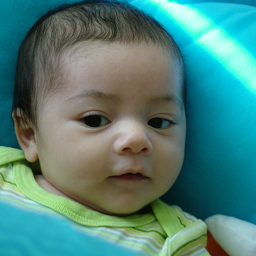

In [8]:
Image_Paths = [os.path.join(root_path, img) for img in os.listdir(root_path)]
Image_Paths 
Image.open(os.path.join(root_path, Image_Paths[0]))

In [9]:
Directory = [path for path in os.listdir(root_path)]
rng = np.random.default_rng(20)
indices = rng.permutation(len(Directory))
split_index = int(len(Directory) * 0.8)
train_indices = indices[:split_index]
val_indices = indices[split_index:]
train_indices.shape, val_indices.shape

((56000,), (14000,))

In [10]:
Train_Paths = [Directory[index] for index in train_indices]
Val_Paths = [Directory[index] for index in val_indices]
np.shape(Train_Paths), np.shape(Val_Paths)

((56000,), (14000,))

In [13]:
Train_Dataset = FacesDataset(root_dir = root_path, names = Train_Paths, minPSNR= minspnr, maxPSNR = maxpsnr, augment = True, grayscale= GREYSCALE, virtSize = 512*Batch_Size, amplification_factor = 1e2)
Val_Dataset = FacesDataset(root_dir = root_path, names = Val_Paths, minPSNR= minspnr, maxPSNR = maxpsnr, augment = False, grayscale= GREYSCALE, virtSize = 128*Batch_Size, amplification_factor = 1e2)
Train_Loader = DataLoader(Train_Dataset, batch_size = Batch_Size, shuffle = True)
Validation_Loader = DataLoader(Val_Dataset, batch_size = Batch_Size, shuffle = False)
Train_Dataset.__len__(), Val_Dataset.__len__()

(16384, 4096)

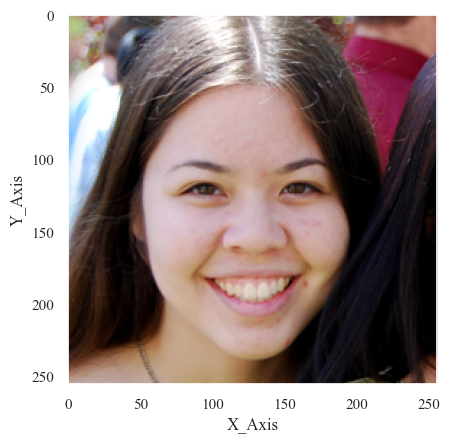

In [14]:
# Presents the untransformed image:
Train_Dataset.show_image(40)

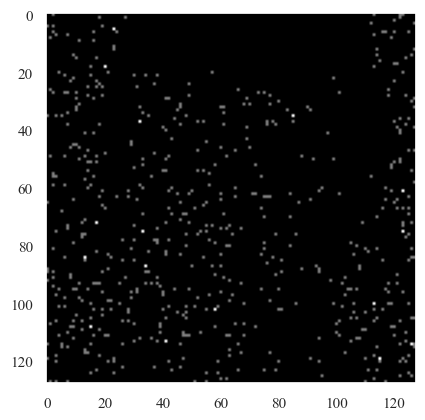

PSNR: -14.306962966918945


In [21]:
ImageNoise, psnr_map, image_target = Train_Dataset.__getitem__(40)
plt.imshow(ImageNoise.detach().cpu().numpy().transpose(1,2,0)[:,:,0], cmap = "gray")
plt.show()
print(f"PSNR: {psnr_map.min().detach().cpu().numpy()}")

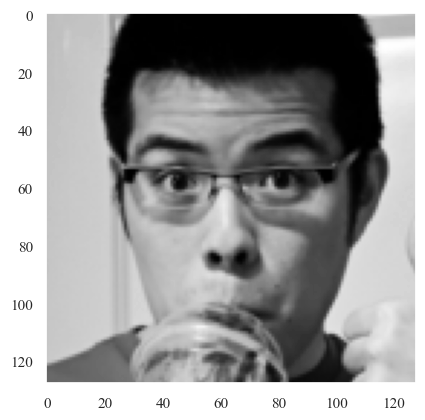

In [22]:
plt.imshow(image_target.detach().cpu().numpy().transpose(1,2,0)[:,:,0], cmap = "gray")
plt.show()

In [31]:
# Define the callbacks for the model training and validation.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, verbose=True, mode='min')
lr_monitor = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min', verbose=True)


# Create the U-net model
in_channels = 1
levels = 10
depth = 6
start_filts = 64
up_mode = 'upsample'
merge_mode = 'concat'

Model = UNet(channels = in_channels, levels=levels, depth=depth,
                start_filts=start_filts, up_mode = up_mode, merge_mode = "concat").to(device)

In [33]:
summary(Model, (1, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           5,824
            Conv2d-2         [-1, 64, 256, 256]          36,928
            Conv2d-3         [-1, 64, 256, 256]          36,928
         MaxPool2d-4         [-1, 64, 128, 128]               0
          DownConv-5  [[-1, 64, 128, 128], [-1, 64, 256, 256]]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
            Conv2d-7        [-1, 128, 128, 128]         147,584
            Conv2d-8        [-1, 128, 128, 128]         147,584
         MaxPool2d-9          [-1, 128, 64, 64]               0
         DownConv-10  [[-1, 128, 64, 64], [-1, 128, 128, 128]]               0
           Conv2d-11          [-1, 256, 64, 64]         295,168
           Conv2d-12          [-1, 256, 64, 64]         590,080
           Conv2d-13          [-1, 256, 64, 64]         590,080
        M

In [34]:
ImageNoise.shape

torch.Size([1, 128, 128])

In [35]:
Model.forward(ImageNoise.unsqueeze(0).to(device)).shape

torch.Size([1, 1, 128, 128])

In [36]:
name = "FacesUNet-256x256"
CHECKPOINT_PATH = "./models/" 
Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=0.5,
                     accelerator= "gpu", devices = [0],
                     max_epochs=max_epochs,
                     callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience=10)])
Trainer.fit(Model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | conv_final | Conv2d     | 65    
1 | down_convs | ModuleList | 125 M 
2 | up_convs   | ModuleList | 53.1 M
------------------------------------------
178 M     Trainable params
0         Non-trainable params
178 M     Total params
715.527   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [37]:
model = UNet.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\OriginalGAPUNet.py:256: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\OriginalGAPUNet.py:257: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


In [ ]:
Trainer.test(model, Train_Loader)

In [ ]:
Trainer.test(model, Train_Loader)

In [85]:
model = UNet.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\OriginalGAPUNet.py:256: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\OriginalGAPUNet.py:257: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


In [86]:
Trainer.test(model, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.14835213124752045    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.14835213124752045}]

In [87]:
Trainer.test(model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -0.1497093290090561    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.1497093290090561}]

In [90]:
model.device

device(type='cpu')

374


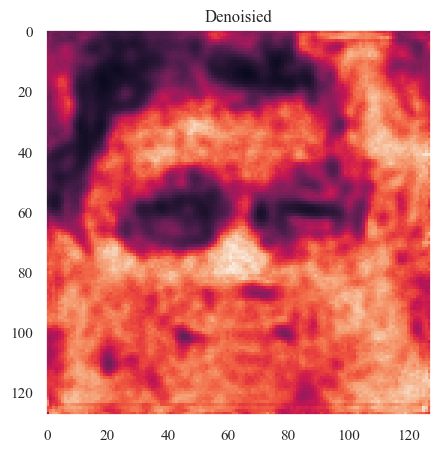

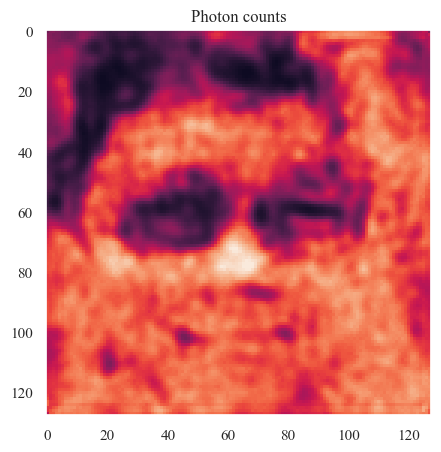

_______________________________________ 374
time (s): 2.429037570953369 time per image (s) 2.429037570953369


In [97]:
import matplotlib.image as mpimg
import time
import numpy as np
from Inference import sample_image

# We are starting with an image containing zeros,
# i.e., sampling from scratch

# we just have 1 channel
channels = 3
# we can sample multiple images at the same time in a batch
batch_size = 1
# for best results this should correspond to training pach size
pixels_x = 128
pixels_y = 128

inp_img =  torch.zeros(batch_size ,channels, pixels_y, pixels_x).to(device)
model = model.to(device)

for i in range(1):
    

    startTime = time.time()
    
    # sampling the image(s)
    #print(inp_img.shape)
    denoised, photons, stack, iterations = sample_image(inp_img,
                                                        model, 
                                                        beta = 0.05,
                                                        save_every_n = 10,
                                                        max_psnr = 40)

    
    # In case we do multiple images in a batch, we show all of them.
    for j in range(denoised.shape[0]):
            print(iterations)

            #print(denoised.shape)
            plt.figure(figsize = (5,5))
            plt.imshow(denoised[j,0], vmin = 0,
                       vmax = np.percentile(denoised[j],99.99))
            plt.title('Denoisied')
            plt.show()
            
            plt.figure(figsize = (5,5))
            plt.imshow(photons[j,0], vmin = 0,
                       vmax = np.percentile(photons[j],99.99))
            plt.title('Photon counts')
            plt.show()
            
            
    
    print('_______________________________________', iterations)
    
    endTime = time.time()
    elapsedTime = endTime - startTime
    print('time (s):', elapsedTime, 'time per image (s)', elapsedTime/denoised.shape[0])

In [95]:
denoised

array([[[[1.3548612e-05, 1.9628151e-05, 2.0777816e-05, ...,
          9.1612164e-06, 1.0656248e-05, 7.0971178e-06],
         [2.1085116e-05, 2.4434810e-05, 2.1956643e-05, ...,
          1.0356080e-05, 1.0566573e-05, 1.0708532e-05],
         [2.2629270e-05, 2.4850404e-05, 2.3296012e-05, ...,
          1.0105425e-05, 9.6702397e-06, 1.0094636e-05],
         ...,
         [3.6895377e-05, 3.6288551e-05, 3.8140653e-05, ...,
          3.1436648e-05, 2.9595985e-05, 2.4286344e-05],
         [3.5250563e-05, 4.1532228e-05, 3.8708156e-05, ...,
          3.1747299e-05, 2.7800135e-05, 2.0670896e-05],
         [2.4732521e-05, 3.1981610e-05, 3.6264420e-05, ...,
          2.3588933e-05, 2.5271234e-05, 2.0346484e-05]],

        [[1.4113405e-05, 2.4502506e-05, 1.9826599e-05, ...,
          9.4650504e-06, 9.2916498e-06, 5.3895083e-06],
         [1.9508549e-05, 2.6936312e-05, 2.3542760e-05, ...,
          7.5403550e-06, 6.7834562e-06, 8.1437274e-06],
         [2.3620247e-05, 2.6276062e-05, 2.5256948e-05, .

In [54]:
Trainer.test(model, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.15227071940898895    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.15227071940898895}]

In [55]:
Trainer.test(model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.15405678749084473    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.15405678749084473}]

In [21]:
name = "FacesUNet-256x256_2"
CHECKPOINT_PATH = "./models/" 
Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=0.5,
                     accelerator= "gpu", devices = [0],
                     max_epochs=max_epochs,
                     callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience=10)])
Trainer.fit(Model, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params
------------------------------------------
0 | conv_final | Conv2d     | 87    
1 | down_convs | ModuleList | 24.1 M
2 | up_convs   | ModuleList | 9.4 M 
------------------------------------------
33.4 M    Trainable params
0         Non-trainable params
33.4 M    Total params
133.794   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [22]:
model = UNet.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)

c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\OriginalGAPUNet.py:256: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
c:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\OriginalGAPUNet.py:257: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


In [23]:
Trainer.test(model, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.12264654040336609    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.12264654040336609}]

In [24]:
Trainer.test(model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.12339131534099579    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.12339131534099579}]

In [45]:
# Define the Attention Unet Model

# Define the Hyperparameters of the Model:
channels = 28
initial_channels = 4
levels = 10
depth = 6
n_heads = 8
dim_k = 64
reduction_factor = 4
num_groups = 4
dropout_rate = 0.40
time_channels = 64
bottleneck_factor = 2
units = 32
bottleneck_units = 64
conv_type = "Residual_Block"
attn_type_list = [None, None, None, None, None, None, None]
merge_type = "add"
middle_attn_type = None
upsample_type = True
maxpsnr = -5.0
transpose = True
minpsnr = -40.0
num_timesteps = 1024
psnr_enabled = False
n_groups = 4
image_channels = 3


# Define the Attention Network:
AttnUNet = AttentionUNet(
        initial_channels = initial_channels,
        channels = channels,
        levels=levels,
        depth=depth,
        n_heads = n_heads,
        dim_k = dim_k,
        dropout_rate = dropout_rate,
        time_channels = time_channels,
        bottleneck_factor = bottleneck_factor,
        units = units,
        bottleneck_units= bottleneck_units,
        conv_type = conv_type,
        attn_type_list = attn_type_list,
        merge_type = merge_type,
        maxpsnr = maxpsnr,
        minpsnr = minpsnr,
        num_timesteps = num_timesteps,
        reduction_factor = reduction_factor,
        num_groups = num_groups,
        middle_attn_type = middle_attn_type,
        upsample_type = upsample_type,
        psnr_enabled = psnr_enabled,
        n_groups=n_groups,
        image_channels = image_channels,
        )

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [46]:
AttnUNet = AttnUNet.to(device)
AttnUNet

AttentionUNet(
  (Image_Projection): LazyConv2d(0, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Temporal_Embedding): Temporal_Embedder(
    (Linear_1): Linear(in_features=4, out_features=16, bias=True)
    (Linear_2): Linear(in_features=16, out_features=16, bias=True)
  )
  (input_norm): GroupNorm(4, 4, eps=1e-05, affine=True)
  (input_Swish): SiLU()
  (Final_Upsample): Up_Block(
    (Conv_Block): Residual_Block(
      (time_embedding): Linear(in_features=16, out_features=4, bias=True)
      (conv1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(4, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (GroupNorm_1): GroupNorm(4, 4, eps=1e-05, affine=True)
      (GroupNorm_2): GroupNorm(4, 4, eps=1e-05, affine=True)
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (Upsample): ConvTranspose2d(28, 4, kernel_size=(2, 2), stride

In [47]:
AttnUNet.forward(ImageNoise.unsqueeze(0).to(device), psnr_map.unsqueeze(0).to(device).min()).shape

torch.Size([1, 3, 128, 128])

In [49]:
name = "FacesAttentionUNet-256x256"
CHECKPOINT_PATH = "./models/" 
Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=0.5,
                     accelerator= "gpu", devices = [0],
                     max_epochs=max_epochs, 
                     callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
                                LearningRateMonitor("epoch"),
                                EarlyStopping('val_loss', patience = 15)])
Trainer.fit(AttnUNet, Train_Loader, Validation_Loader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name               | Type              | Params
----------------------------------------------------------
0  | Image_Projection   | Conv2d            | 1.1 K 
1  | Temporal_Embedding | Temporal_Embedder | 352   
2  | input_norm         | GroupNorm         | 8     
3  | input_Swish        | SiLU              | 0     
4  | Final_Upsample     | Up_Block          | 840   
5  | DownBlocks         | ModuleList        | 15.0 M
6  | MiddleBlocks       | ModuleList        | 30.5 M
7  | UpBlocks           | ModuleList        | 7.2 M 
8  | outp

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [53]:
Trainer.test(AttnUNet, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   -0.14729341864585876    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.14729341864585876}]

In [54]:
Trainer.test(AttnUNet, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -0.1456553190946579    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -0.1456553190946579}]